## GAN starter code


In [ ]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 53.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [ ]:
import os

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

import pytorch_lightning as pl


random_seed = 42
torch.manual_seed(random_seed)

BATCH_SIZE=128
AVAIL_GPUS = min(1, torch.cuda.device_count())
NUM_WORKERS=int(os.cpu_count() / 2)

In [ ]:
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./data",
                 batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,)),
            ]
        )

    def prepare_data(self):
        MNIST(self.data_dir, train=True, download=True)
        MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        # Assign train/val datasets
        if stage == "fit" or stage is None:
            mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

        # Assign test dataset
        if stage == "test" or stage is None:
            self.mnist_test = MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=self.num_workers)

**self.transform**: Acá se define una serie de transformaciones que se aplicarán a las imágenes. En este caso, las imágenes se convierten en tensores (un tipo de dato que PyTorch puede manejar) y luego se normalizan.

**mnist_full:** Carga todo el conjunto de datos de entrenamiento.

**random_split**: Divide los datos de entrenamiento en dos conjuntos: uno para entrenamiento (mnist_train) y otro para validación (mnist_val).

**self.mnist_test**: Carga el conjunto de datos de prueba.


MNISTDataModule es una clase que maneja la carga, transformación y preparación del conjunto de datos MNIST.

prepare_data descarga los datos.

setup divide los datos en conjuntos de entrenamiento, validación y prueba.

train_dataloader, val_dataloader, y test_dataloader proporcionan los datos en lotes para el entrenamiento, validación y prueba, respectivamente.

In [ ]:
# Detective: fake or no fake -> 1 output [0, 1]
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # Simple CNN
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Flatten the tensor so it can be fed into the FC layers
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return torch.sigmoid(x)

In [ ]:
# Generate Fake Data: output like real data [1, 28, 28] and values -1, 1
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.lin1 = nn.Linear(latent_dim, 7*7*64)  # [n, 256, 7, 7]
        self.ct1 = nn.ConvTranspose2d(64, 32, 4, stride=2) # [n, 64, 16, 16]
        self.ct2 = nn.ConvTranspose2d(32, 16, 4, stride=2) # [n, 16, 34, 34]
        self.conv = nn.Conv2d(16, 1, kernel_size=7)  # [n, 1, 28, 28]


    def forward(self, x):
        # Pass latent space input into linear layer and reshape
        x = self.lin1(x) #Transforma el vector de entrada en un tensor de tamaño 7*7*64.
        x = F.relu(x)
        x = x.view(-1, 64, 7, 7)  #256    Redimensiona el tensor a [batch_size, 64, 7, 7]

        # Upsample (transposed conv) 16x16 (64 feature maps)
        x = self.ct1(x)  #Aplica otra convolución transpuesta para aumentar el tamaño de la imagen a 16*16.
        x = F.relu(x)

        # Upsample to 34x34 (16 feature maps)
        x = self.ct2(x) #Aplica otra convolución transpuesta para aumentar el tamaño de la imagen a 34x34.
        x = F.relu(x)

        # Convolution to 28x28 (1 feature map)
        return self.conv(x)   #aplica una convolución para ajustar el tamaño de la imagen a 28x28 y reducir los canales a 1 (escala de grises).

In [ ]:
# TODO: GAN

In [ ]:
class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()      #Pasamos a inicializar los atributos
        self.save_hyperparameters()
        self.generator = Generator(latent_dim=self.hparams.latent_dim) ###Clase de arriba a la cual le pasamos latent space como atributo
        self.discriminator = Discriminator()
        #Random noise
        self.validation_z = torch.rand(6, self.hparams.latent_dim)

    def forward(self, z):
      return self.generator(z)

    def adversarial_loss(self, y_hat, y):      #prediciion vs observaciones
      return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx, optimizer_idx):
      real_imgs, _ = batch

      # Sample noise
      z = torch.rand(real_imgs.shape[0], self.hparams.latent_dim)
      z = z.type_as(real_imgs)

      # Train generator
      if optimizer_idx == 0:
        # Generate images
        fake_imgs = self(z)
        # Log loss
        y_hat = self.discriminator(fake_imgs)
        y = torch.ones(real_imgs.size(0), 1)
        y = y.type_as(real_imgs)
        g_loss = self.adversarial_loss(y_hat, y)
        tqdm_dict = {"g_loss": g_loss}
        return {"loss": g_loss, "progress_bar": tqdm_dict, "log": tqdm_dict}
      if optimizer_idx == 1:
        # Train discriminator
        # Generate images
        fake_imgs = self(z)

        #Analiszmaos que tan real es el label
        y_hat_real = self.discriminator(real_imgs)
        y_real = torch.ones(real_imgs.size(0), 1)
        y_real = y_real.type_as(real_imgs)
        real_loss = self.adversarial_loss(y_hat_real, y_real)

        #Analizamos que tan fake es el label
        y_hat_fake = self.discriminator(self(z).detach()) #Para no interrumpir con los datos del grafico
        y_fake = torch.zeros(real_imgs.size(0), 1)
        y_fake = y_fake.type_as(real_imgs)
        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

        #Log loss     (TOTAL LOSS)
        d_loss = real_loss + fake_loss
        tqdm_dict = {"d_loss": d_loss}
        return {"loss": d_loss, "progress_bar": tqdm_dict, "log": tqdm_dict}

    def configure_optimizers(self):
      lr = self.hparams.lr
      opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
      opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
      return [opt_g, opt_d]

    def plot_imgs(self):
      z = self.validation_z.type_as(self.generator.lin1.weight)
      sample_imgs = self(z).cpu()
      print("epoch", self.current_epoch)
      fig = plt.figure(figsize=(10, 8))
      for i in range (sample_imgs.size(0)):
        plt.subplot(2, 3, i+1)
        plt.tight_layout()
        plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap="gray", interpolation="none")
        plt.title("Generated Data")
        plt.xticks([])
        plt.yticks([])
    def on_epoch_end(self):
      self.plot_imgs()


from re import A
trainer = pl.Trainer(max_epochs=20, devices=AVAIL_GPUS, accelerator="gpu")
trainer.fit(model, datamodule=datamodule)


In [ ]:
#Ahora queremos entrenarlo


datamodule = MNISTDataModule()
model = GAN(latent_dim=100, lr=0.0002)

epoch 0


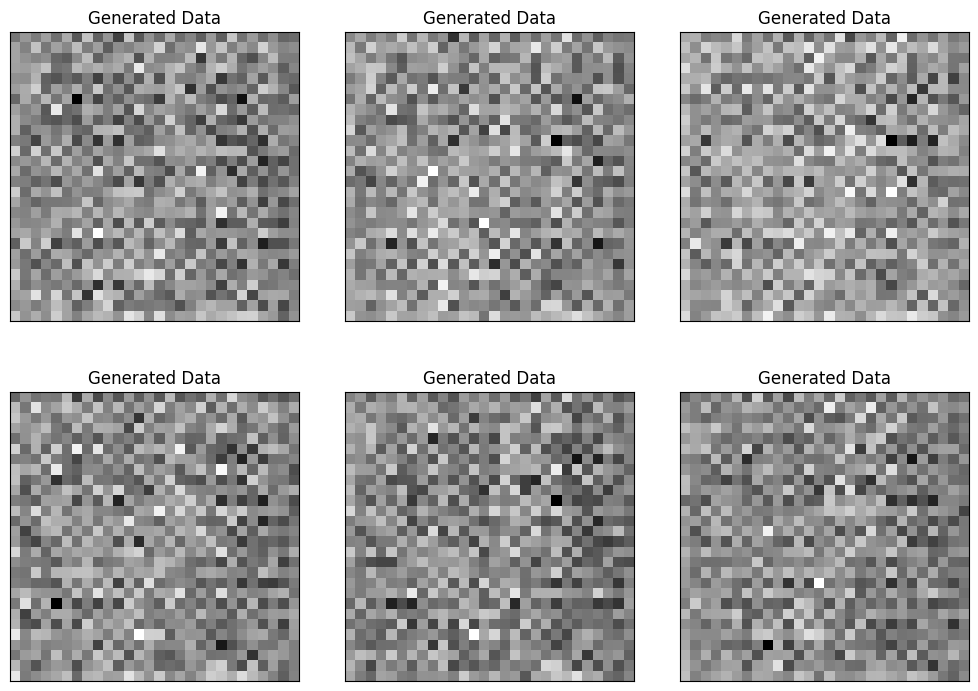

In [ ]:
model.plot_imgs()

Podemos ver que sin entrenar genera imagenes con ruido


In [ ]:
from re import A
trainer = pl.Trainer(max_epochs=20, devices=AVAIL_GPUS, accelerator="gpu")
trainer.fit(model, datamodule=datamodule)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: Training with multiple optimizers is only supported with manual optimization. Remove the `optimizer_idx` argument from `training_step`, set `self.automatic_optimization = False` and access your optimizers in `training_step` with `opt1, opt2, ... = self.optimizers()`.

In [ ]:
import torch
import pytorch_lightning as pl
import torch.nn.functional as F
import matplotlib.pyplot as plt

class GAN(pl.LightningModule):
    def __init__(self, latent_dim=100, lr=0.0002):
        super().__init__()
        self.save_hyperparameters()
        self.generator = Generator(latent_dim=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        self.validation_z = torch.rand(6, self.hparams.latent_dim)
        self.automatic_optimization = False  # Desactivamos la optimización automática

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        real_imgs, _ = batch
        opt_g, opt_d = self.optimizers()  # Obtener optimizadores manualmente
        z = torch.rand(real_imgs.size(0), self.hparams.latent_dim).type_as(real_imgs)

        # ---- Entrenamiento del generador ----
        fake_imgs = self(z)
        y_hat = self.discriminator(fake_imgs)
        y = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
        g_loss = self.adversarial_loss(y_hat, y)

        self.manual_backward(g_loss)
        opt_g.step()
        opt_g.zero_grad()

        # ---- Entrenamiento del discriminador ----
        y_hat_real = self.discriminator(real_imgs)
        y_real = torch.ones(real_imgs.size(0), 1).type_as(real_imgs)
        real_loss = self.adversarial_loss(y_hat_real, y_real)

        y_hat_fake = self.discriminator(fake_imgs.detach())
        y_fake = torch.zeros(real_imgs.size(0), 1).type_as(real_imgs)
        fake_loss = self.adversarial_loss(y_hat_fake, y_fake)

        d_loss = real_loss + fake_loss

        self.manual_backward(d_loss)
        opt_d.step()
        opt_d.zero_grad()

        # Registro de pérdidas
        self.log("g_loss", g_loss, prog_bar=True)
        self.log("d_loss", d_loss, prog_bar=True)

    def configure_optimizers(self):
        lr = self.hparams.lr
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr)
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr)
        return [opt_g, opt_d]

    def plot_imgs(self):
        z = self.validation_z.type_as(self.generator.lin1.weight)
        sample_imgs = self(z).cpu()
        print("epoch", self.current_epoch)
        fig = plt.figure(figsize=(10, 8))
        for i in range(sample_imgs.size(0)):
            plt.subplot(2, 3, i + 1)
            plt.tight_layout()
            plt.imshow(sample_imgs.detach()[i, 0, :, :], cmap="gray", interpolation="none")
            plt.title("Generated Data")
            plt.xticks([])
            plt.yticks([])
        plt.show()

    def on_epoch_end(self):
        self.plot_imgs()


# Entrenamiento
trainer = pl.Trainer(max_epochs=20, devices=AVAIL_GPUS, accelerator="gpu")
trainer.fit(model, datamodule=datamodule)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


RuntimeError: Training with multiple optimizers is only supported with manual optimization. Remove the `optimizer_idx` argument from `training_step`, set `self.automatic_optimization = False` and access your optimizers in `training_step` with `opt1, opt2, ... = self.optimizers()`.